Create two clusters of points in R2, each with 2000 points, that are separated by a parabolic boundary. 

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pandas as pd

# 6.6.1

In [23]:
N_DATA = 2000
STD = 0.5


In [368]:
def get_data(N_DATA, STD):
    x=np.zeros(shape=(2*N_DATA,3))
    r=np.random.normal(0,STD,2*N_DATA)
    theta=2*np.pi*np.random.rand(2*N_DATA)


    # Get random floats betewen -6 and +6 of size N_DATA
    h=-6+12*np.random.rand(N_DATA)

    # Creating a parabolic function with input data
    v=5+(h**2)/6

    # Creating training data for the first class
    # Adding noise to features 2D coordinates
    x[0:N_DATA,0] = h + r[0:N_DATA]*np.cos(theta[0:N_DATA])
    x[0:N_DATA,1] = v + r[0:N_DATA]*np.sin(theta[0:N_DATA])
    x[0:N_DATA,2] = 0

    # Get random floats betewen -5 and +5 of size N_DATA
    h=-5+10*np.random.rand(N_DATA)

    # Creating a parabolic function with input data
    v=10+(h**2)/4

    # Creating training data for the first class
    # Adding noise to feature and label
    x[N_DATA:,0] = h + r[N_DATA:]*np.cos(theta[N_DATA:])
    x[N_DATA:,1] = v + r[N_DATA:]*np.sin(theta[N_DATA:])
    x[N_DATA:,2] = 1

    return x

def preprocess_shuffle(data):
    # Normalizing data
    data[:,0]= (data[:,0] - min(data[:,0])) / ( max(data[:,0]) - min(data[:,0]) )
    data[:,1]= (data[:,1] - min(data[:,1])) / ( max(data[:,1]) - min(data[:,1]) )

    np.random.shuffle(data)
    return data

In [369]:
X = get_data(N_DATA, STD)

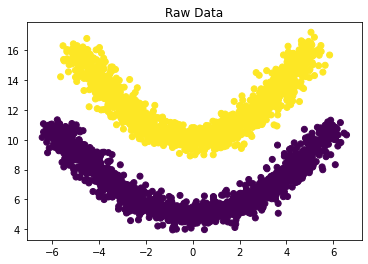

In [370]:
fig,ax = plt.subplots(1,1)
path = ax.scatter(X[:,0],X[:,1],c=X[:,2])
_ = ax.set_title("Raw Data")

In [372]:
X = preprocess_shuffle(X)

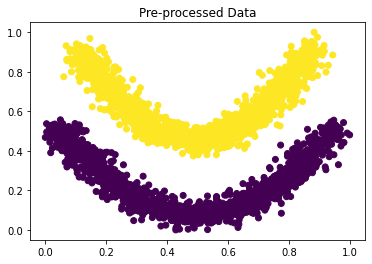

In [373]:
fig,ax = plt.subplots(1,1)
path = ax.scatter(X[:,0],X[:,1],c=X[:,2])
_ = ax.set_title("Pre-processed Data")

Design a 2/2-1 neural network with rectilinear activating functions to classify these points by finding the optimal parameter values using the back propagation algorithm on 1000 randomly selected points


In [374]:
def NN_Forward_Relu(x_,params):
    w11, w12, w21, w22, b1, b2, ww1, ww2, bb = params
    # Layer 1
    ## Neuron 1
    y1 = b1 + (w11*x_[0]) + (w12*x_[1])
    ## Neuron 2
    y2 = b2 + (w21*x_[0]) + (w22*x_[1])
    ## Activation Function
    dxx1=y1>0
    dxx2=y2>0
    xx1=y1*dxx1
    xx2=y2*dxx2
    # Layer 2
    ## Neuron 1
    yy = bb + (ww1*xx1) + (ww2*xx2)
    yy = yy>0

    intermediate_params = dxx1, xx1, dxx2, xx2
    return intermediate_params, yy
    
def update_weights(initial_params,intermediate_params,a,error,x_):
    w11, w12, w21, w22, b1, b2, ww1, ww2, bb = initial_params
    dxx1, xx1, dxx2, xx2 = intermediate_params
    ww1+=a*error*xx1
    ww2+=a*error*xx2 
    bb+=a*error
    w11+=a*error*ww1*dxx1*x_[0]
    w12+=a*error*ww1*dxx1*x_[1]
    w21+=a*error*ww2*dxx2*x_[0]
    w22+=a*error*ww2*dxx2*x_[1]
    b1+=a*error*ww1*dxx1
    b2+=a*error*ww2*dxx2

    return (w11, w12, w21, w22, b1, b2, ww1, ww2, bb)

def training_loop(N_EPOCH,initial_params,X, NN_FORWARD_TYPE):
    err_training = []
    w11f = []
    w12f =[]
    for epoch in range(0,N_EPOCH):
        for train_x in X:
            # Forward Pass of Neural Network
            intermediate_params, yy = NN_FORWARD_TYPE(train_x,initial_params)
            
            # Error
            e=train_x[2]-yy
            err_training.append(e)
            
            # Update Weights
            initial_params = update_weights(initial_params,
                                            intermediate_params,
                                            ALPHA,e,
                                            train_x)
            
            # Tracking final weights after each loop
            # print("Initial Params ", initial_params[0])
            w11f.append(initial_params[0])
            w12f.append(initial_params[1])

    return (initial_params,w11f,w12f) , (err_training)

def testing_loop(Y,final_params, NN_FORWARD_TYPE):
    err = 0
    for test_y in Y: 
        _, final_yy = NN_FORWARD_TYPE(test_y,
                                final_params)
        e=abs(test_y[2]-final_yy)
        err+=e
    # Calculating MAE
    err=err/len(Y)
    return err



In [32]:
N_DATA = 2000
STD = 0.5

successful = []
a_1 = np.arange(0.001,0.01,0.001)
a_2 = np.arange(0.01,0.05,0.01)
alphas = np.concatenate((a_1,a_2))
epochs = range(1,7)

all_data = get_data(N_DATA, STD)
all_data = preprocess_shuffle(all_data)

train = all_data[:1000]
test = all_data[1000:3000]


for ALPHA in alphas:
  ALPHA = round(ALPHA,4)
  for N_EPOCH in epochs:
    print( ".", sep=' ', end=' ', flush=True)
    for i in range(50):
      # Initailizing Parameters (9 in total)
      params = tuple(0.5-np.random.rand() for i in range(9)) 

      (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                              params,
                                                              train,
                                                              NN_Forward_Relu)
      err = testing_loop(test,final_params, NN_Forward_Relu)

      if err < 0.05:
          successful.append((final_params,err,ALPHA,N_EPOCH))

results = pd.DataFrame(successful, 
                       columns=["final_params","err","ALPHA","N_EPOCH"])

summary_results = pd.pivot_table(results,values='err',index='ALPHA',
                                 columns=['N_EPOCH'],aggfunc='count')

summary_results.style.background_gradient(cmap='Greens')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

N_EPOCH,1,2,3,4,5,6
ALPHA,,,,,,
0.001,nan,1.000000,nan,1.000000,1.000000,1.000000
0.002,nan,2.000000,nan,nan,2.000000,1.000000
0.003,nan,nan,1.000000,1.000000,1.000000,2.000000
0.004,1.000000,1.000000,3.000000,2.000000,4.000000,2.000000
0.005,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000
0.006,nan,4.000000,2.000000,4.000000,2.000000,1.000000
0.007,1.000000,3.000000,2.000000,nan,2.000000,3.000000
0.008,1.000000,3.000000,2.000000,1.000000,2.000000,6.000000
0.009,3.000000,1.000000,2.000000,3.000000,3.000000,1.000000


### Selecting 6 Epochs and Learning rate of 0.01


In [33]:
def plotting_3_figs(NN_FORWARD_TYPE):
  fig = plt.figure(figsize=(15,5))
  fig.suptitle(f'Error: {round(err,4)} \n Final Params {[round(p,1) for p in final_params]}')
  ax0 = fig.add_subplot(131)
  ax1 = fig.add_subplot(132)
  ax2 = fig.add_subplot(133, projection='3d')

  ax0.scatter(train[:,0], train[:,1],c=train[:,2], label="Train")
  ax0.scatter(test[:,0], test[:,1], c=test[:,2], label="Test")

  # Producing set of inputs for Decision Boundary
  X_mesh,Y_mesh = np.meshgrid(np.arange(0.25,1.75,0.02),
                np.arange(1.25,2.75,0.02))

  # Assigning label to set of inputs
  _, Z_mesh = NN_FORWARD_TYPE([X_mesh,Y_mesh],final_params)
              
  ax0.scatter(X_mesh,Y_mesh,c=Z_mesh,alpha=0.2)
  ax0.set_title("2D Decision Boundary")

  ax1_1 = ax1.twinx()

  f = np.arange(0,N_EPOCH*len(train),1)
  
  line1, =ax1.plot(f,w11f,c='b',label='w11')
  line2, = ax1_1.plot(f,w12f,c='r',label='w12')

  ax1.set_ylabel('w11')
  ax1_1.set_ylabel('w12')
  
  plt.legend(loc='center right', handles=[line1, line2])
  
  ax2.plot_surface(X_mesh,Y_mesh,Z_mesh,rstride=1,cstride=1,cmap='viridis',alpha=0.2)
  ax2.scatter(train[:,0], train[:,1],train[:,2],c=train[:,2], label="Train")
  ax2.scatter(test[:,0], test[:,1],test[:,2], c=test[:,2], label="Test")
  
  fig.tight_layout(rect=[0, 0.03, 1, 0.93])



True


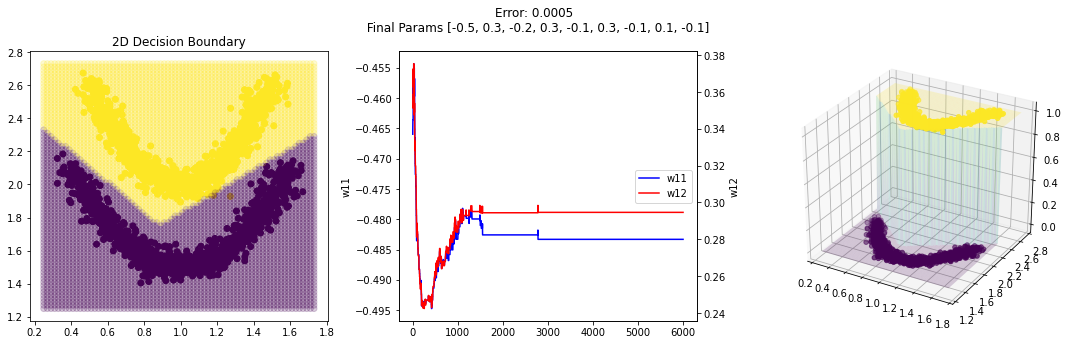

In [54]:
N_DATA = 2000
STD = 0.5

successful = []

all_data = get_data(N_DATA, STD)
all_data = preprocess_shuffle(all_data)

train = all_data[:1000]
test = all_data[1000:3000]

## Selecting 6 Epochs and Learning rate of 0.01
epochs=[6,]
alphas=[0.02]
for N_EPOCH in epochs:
  for ALPHA in alphas:
    for i in range(50):
      # Initailizing Parameters (9 in total)
      params = tuple(0.5-np.random.rand() for i in range(9)) 

      (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                              params,
                                                              train,
                                                              NN_Forward_Relu)
      err = testing_loop(test,final_params, NN_Forward_Relu)

      if err < 0.05:
        print(True)
        plotting_3_figs(NN_Forward_Relu)
        break
    else:
      continue
    break
  else:
    continue
  break
      



# 6.6.2

In [378]:
def NN_Forward_RELU_18(x_,params):
    w11, w12, w21, w22, w31, w32, w41, w42, b1, b2, b3, b4, bb, ww1, ww2, ww3, ww4, bb = params
    # Layer 1
    ## Neuron 1
    y1 = b1 + (w11*x_[0]) + (w12*x_[1])
    ## Neuron 2
    y2 = b2 + (w21*x_[0]) + (w22*x_[1])
    ## Neuron 3
    y3 = b3 + (w31*x_[0]) + (w32*x_[1])
    ## Neuron 4
    y4 = b4 + (w41*x_[0]) + (w42*x_[1])
    ## Activation Function
    dxx1=y1>0
    dxx2=y2>0
    dxx3=y3>0
    dxx4=y4>0
    xx1=y1*dxx1
    xx2=y2*dxx2
    xx3=y3*dxx3
    xx4=y4*dxx4
    # Layer 2
    ## Neuron 1
    yy = bb + (ww1*xx1) + (ww2*xx2) + (ww3*xx3) + (ww3*xx3) + (ww4*xx4)
    yy = yy>0

    intermediate_params = dxx1, xx1, dxx2, xx2, dxx3, xx3, dxx4, xx4
    return intermediate_params, yy
    
def update_weights(initial_params,intermediate_params,a,error,x_):
    w11, w12, w21, w22, w31, w32, w41, w42, b1, b2, b3, b4, bb, ww1, ww2, ww3, ww4, bb = initial_params
    dxx1, xx1, dxx2, xx2, dxx3, xx3, dxx4, xx4 = intermediate_params
    ww1+=a*error*xx1
    ww2+=a*error*xx2 
    ww3+=a*error*xx3
    ww4+=a*error*xx4 
    bb+=a*error
    w11+=a*error*ww1*dxx1*x_[0]
    w12+=a*error*ww1*dxx1*x_[1]
    w21+=a*error*ww2*dxx2*x_[0]
    w22+=a*error*ww2*dxx2*x_[1]
    w31+=a*error*ww3*dxx3*x_[0]
    w32+=a*error*ww3*dxx3*x_[1]
    w41+=a*error*ww4*dxx4*x_[0]
    w42+=a*error*ww4*dxx4*x_[1]
    b1+=a*error*ww1*dxx1
    b2+=a*error*ww2*dxx2
    b3+=a*error*ww3*dxx3
    b4+=a*error*ww4*dxx4

    return (w11, w12, w21, w22, w31, w32, w41, w42, b1, b2, b3, b4, bb, ww1, ww2, ww3, ww4, bb)

In [73]:
N_DATA = 2000
STD = 0.5

successful = []
a_1 = np.arange(0.001,0.01,0.001)
a_2 = np.arange(0.01,0.05,0.01)
alphas = np.concatenate((a_1,a_2))
epochs = range(1,7)

all_data = get_data(N_DATA, STD)
all_data = preprocess_shuffle(all_data)

train = all_data[:1000]
test = all_data[1000:3000]

for N_EPOCH in epochs:
  for ALPHA in alphas:
    print(".", sep=' ', end=' ', flush=True)
    ALPHA = round(ALPHA,4)
    for i in range(50):
      # Initailizing Parameters (18 in total)
      params = tuple(0.5-np.random.rand() for i in range(18)) 

      (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                              params,
                                                              train,
                                                              NN_Forward_RELU_18)
      err = testing_loop(test,final_params,NN_Forward_RELU_18)

      if err < 0.05:
        successful.append((final_params,err,ALPHA,N_EPOCH))

results = pd.DataFrame(successful, 
                             columns=["final_params","err","ALPHA","N_EPOCH"])

summary_results = pd.pivot_table(results,values='err',index='ALPHA',
                                  columns=['N_EPOCH'],aggfunc='count')

summary_results.style.background_gradient(cmap='Greens')


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

N_EPOCH,1,2,3,4,5,6
ALPHA,,,,,,
0.001,nan,2.000000,2.000000,2.000000,5.000000,4.000000
0.002,2.000000,5.000000,4.000000,9.000000,8.000000,5.000000
0.003,4.000000,4.000000,2.000000,5.000000,2.000000,7.000000
0.004,2.000000,8.000000,6.000000,3.000000,8.000000,12.000000
0.005,2.000000,3.000000,6.000000,8.000000,8.000000,5.000000
0.006,3.000000,5.000000,8.000000,11.000000,6.000000,6.000000
0.007,6.000000,3.000000,4.000000,9.000000,6.000000,10.000000
0.008,1.000000,10.000000,9.000000,10.000000,7.000000,7.000000
0.009,4.000000,9.000000,7.000000,12.000000,7.000000,5.000000


### Selecting 4 Epochs and Learning rate of 0.009


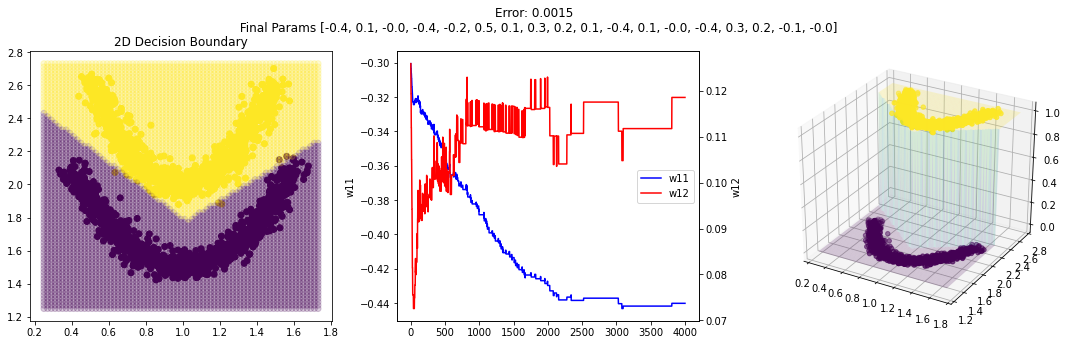

In [83]:
N_DATA = 2000
STD = 0.5

successful = []

all_data = get_data(N_DATA, STD)
all_data = preprocess_shuffle(all_data)

train = all_data[:1000]
test = all_data[1000:3000]

## Selecting 6 Epochs and Learning rate of 0.01
epochs=[4,]
alphas=[0.009,]
for N_EPOCH in epochs:
  for ALPHA in alphas:
    for i in range(50):
      # Initailizing Parameters (18 in total)
      params = tuple(0.5-np.random.rand() for i in range(18)) 

      (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                              params,
                                                              train,
                                                              NN_Forward_RELU_18)
      err = testing_loop(test,final_params, NN_Forward_RELU_18)

      if err < 0.05:
        plotting_3_figs(NN_Forward_RELU_18)
        break

# 6.6.4

In [85]:
from math import exp

In [420]:
def sig_f(x):
  f = 1/(1+np.exp(-x))
  return f

def NN_Forward_Sigmoid_threshold(x_,params):
  """
  Uses a sigmoid activation function. 
  Last layer has a threshold of 0.5
  """
  w11, w12, w21, w22, w31, w32, w41, w42, b1, b2, b3, b4, bb, ww1, ww2, ww3, ww4, bb = params
  # Layer 1
  ## Neuron 1
  y1 = b1 + (w11*x_[0]) + (w12*x_[1])
  ## Neuron 2
  y2 = b2 + (w21*x_[0]) + (w22*x_[1])
  ## Neuron 3
  y3 = b3 + (w31*x_[0]) + (w32*x_[1])
  ## Neuron 4
  y4 = b4 + (w41*x_[0]) + (w42*x_[1])
  ## Activation Function
  xx1 = sig_f(y1) 
  xx2 = sig_f(y2) 
  xx3 = sig_f(y3) 
  xx4 = sig_f(y4) 
  dxx1= xx1*(1-xx1)
  dxx2= xx2*(1-xx2)
  dxx3= xx3*(1-xx3)
  dxx4= xx4*(1-xx4)
  # Layer 2
  ## Neuron 1
  yy = sig_f(bb + (ww1*xx1) + (ww2*xx2) + (ww3*xx3) + (ww3*xx3) + (ww4*xx4))
  yy = yy>0.5

  intermediate_params = dxx1, xx1, dxx2, xx2, dxx3, xx3, dxx4, xx4
  return intermediate_params, yy


In [379]:
N_DATA = 2000
STD = 0.5

successful = []

all_data = get_data(N_DATA, STD)

add_data = preprocess_shuffle(all_data)
train = all_data[:1000]
test = all_data[1000:3000]

epochs=[4,]
alphas=[0.009,]
errs = {}
for N_EPOCH in epochs:
  for ALPHA in alphas:
    for NN_FUNC, func_name in [(NN_Forward_Sigmoid_threshold, "Sigmoid"), (NN_Forward_RELU_18, "Relu")]:
      errs[func_name] = np.zeros((50,))
      running_count = 0
      for i in range(50):
        # Initailizing Parameters (18 in total) 
        # USING PARAMETERS BETWEEN -1 TO 1 
        params = tuple((np.random.rand()*2)-1  for i in range(18)) 

        (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                                params,
                                                                train,
                                                                NN_FUNC)
        err = testing_loop(test,final_params,NN_FUNC)
        if err < 0.05:
          running_count+=1

        errs[func_name][i] = running_count

Text(0.5, 1.0, 'Sigmoid vs Relu Activation Function 0.05 Threshold')

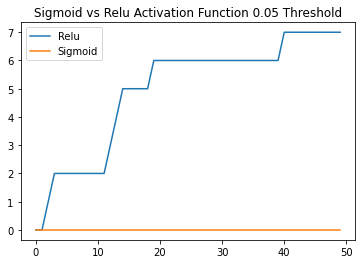

In [355]:
fig,ax = plt.subplots()

ax.plot(errs['Relu'], label='Relu')
ax.plot(errs['Sigmoid'], label='Sigmoid')
ax.legend()
ax.set_title("Sigmoid vs Relu Activation Function 0.05 Threshold")

# 6.6.5

In [120]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving approximatemeifyoucan.npy to approximatemeifyoucan.npy
User uploaded file "approximatemeifyoucan.npy" with length 96128 bytes


In [381]:

successful = []

all_data = np.load('approximatemeifyoucan.npy').T
# Normalizing features data 
all_data = preprocess_shuffle(all_data)

train = all_data[:3000]
test = all_data[3000:]


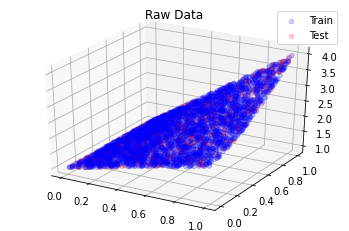

In [382]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(train[:,0], train[:,1],train[:,2],c='b',label="Train",alpha=0.2)
ax.scatter(test[:,0], test[:,1],test[:,2], c='r', label="Test",alpha=0.2)
plt.legend()
_ = ax.set_title("Raw Data")

In [421]:
def NN_Forward_Sigmoid_25(x_,params):
    w11, w12, w21, w22, w31, w32, w41, w42, w51, w52, w61, w62, b1, b2, b3, b4, b5, b6, bb, ww1, ww2, ww3, ww4, ww5, ww6, bb = params
    # Layer 1
    ## Neuron 1
    y1 = b1 + (w11*x_[0]) + (w12*x_[1])
    ## Neuron 2
    y2 = b2 + (w21*x_[0]) + (w22*x_[1])
    ## Neuron 3
    y3 = b3 + (w31*x_[0]) + (w32*x_[1])
    ## Neuron 4
    y4 = b4 + (w41*x_[0]) + (w42*x_[1])
    ## Neuron 5
    y5 = b5 + (w51*x_[0]) + (w52*x_[1])
    ## Neuron 6
    y6 = b6 + (w61*x_[0]) + (w62*x_[1])
    ## Activation Function
    xx1 = sig_f(y1) 
    xx2 = sig_f(y2) 
    xx3 = sig_f(y3) 
    xx4 = sig_f(y4) 
    xx5 = sig_f(y5) 
    xx6 = sig_f(y6) 
    dxx1= xx1*(1-xx1)
    dxx2= xx2*(1-xx2)
    dxx3= xx3*(1-xx3)
    dxx4= xx4*(1-xx4)
    dxx5= xx5*(1-xx5)
    dxx6= xx6*(1-xx6)
    # Layer 2
    ## Neuron 1
    yy = bb + (ww1*xx1) + (ww2*xx2) + (ww3*xx3) + (ww3*xx3) + (ww4*xx4) + (ww5*xx5) + (ww6*xx6)

    intermediate_params = dxx1, xx1, dxx2, xx2, dxx3, xx3, dxx4, xx4, dxx5, xx5, dxx6, xx6
    return intermediate_params, yy
    
def update_weights(initial_params,intermediate_params,a,error,x_):
    w11, w12, w21, w22, w31, w32, w41, w42, w51, w52, w61, w62, b1, b2, b3, b4, b5, b6, bb, ww1, ww2, ww3, ww4, ww5, ww6, bb = initial_params
    dxx1, xx1, dxx2, xx2, dxx3, xx3, dxx4, xx4, dxx5, xx5, dxx6, xx6 = intermediate_params
    ww1+=a*error*xx1
    ww2+=a*error*xx2 
    ww3+=a*error*xx3
    ww4+=a*error*xx4 
    ww5+=a*error*xx5
    ww6+=a*error*xx6 
    bb+=a*error
    w11+=a*error*ww1*dxx1*x_[0]
    w12+=a*error*ww1*dxx1*x_[1]
    w21+=a*error*ww2*dxx2*x_[0]
    w22+=a*error*ww2*dxx2*x_[1]
    w31+=a*error*ww3*dxx3*x_[0]
    w32+=a*error*ww3*dxx3*x_[1]
    w41+=a*error*ww4*dxx4*x_[0]
    w42+=a*error*ww4*dxx4*x_[1]
    w51+=a*error*ww5*dxx5*x_[0]
    w52+=a*error*ww5*dxx5*x_[1]
    w61+=a*error*ww6*dxx6*x_[0]
    w62+=a*error*ww6*dxx6*x_[1]
    b1+=a*error*ww1*dxx1
    b2+=a*error*ww2*dxx2
    b3+=a*error*ww3*dxx3
    b4+=a*error*ww4*dxx4
    b5+=a*error*ww5*dxx5
    b6+=a*error*ww6*dxx6

    return (w11, w12, w21, w22, w31, w32, w41, w42, w51, w52, w61,
            w62, b1, b2, b3, b4, b5, b6, bb, ww1, ww2, ww3, ww4, ww5, ww6, bb)


0.04
4 5 6 

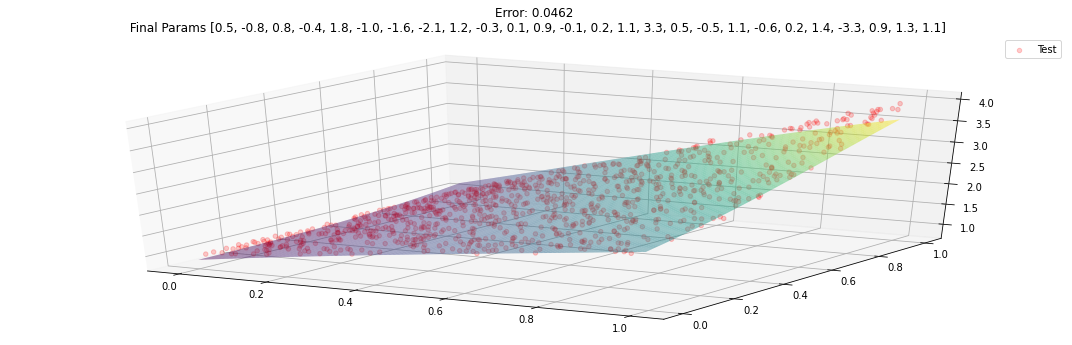

In [396]:
alphas = [0.04]
epochs = range(4,8)
errs =[]
for ALPHA in alphas:
  ALPHA = round(ALPHA,4)
  print(f"\n{ALPHA}")
  for N_EPOCH in epochs:
    print(N_EPOCH, sep=' ', end=' ', flush=True)
    for i in range(50):
      # Initailizing Parameters (26 in total)
      # USING PARAMETERS BETWEEN -1 TO 1 
      params = tuple((np.random.rand()*2)-1 for i in range(26)) 

      (final_params,w11f,w12f), (err_training) = training_loop(N_EPOCH,
                                                              params,
                                                              train,
                                                              NN_Forward_Sigmoid_25)
      err = testing_loop(test,final_params,NN_Forward_Sigmoid_25)
      errs.append(err)
      if err <= 0.06:
        successful.append((final_params,err,ALPHA,N_EPOCH))
        fig = plt.figure(figsize=(15,5))
        fig.suptitle(f'Error: {round(err,4)} \n Final Params {[round(p,1) for p in final_params]}')
        ax = fig.add_subplot(111, projection='3d')

        # Producing set of inputs for Decision Boundary
        X_mesh,Y_mesh = np.meshgrid(np.arange(0,1,0.01),
                      np.arange(0,1,0.01))

        # Assigning label to set of inputs
        _, Z_mesh = NN_Forward_Sigmoid_25([X_mesh,Y_mesh],final_params)
                
        ax.plot_surface(X_mesh,Y_mesh,Z_mesh,rstride=1,cstride=1,cmap='viridis',alpha=0.5)       
        ax.scatter(test[:,0], test[:,1],test[:,2], c='r', label="Test",alpha=0.2)
        ax.legend()
        fig.tight_layout(rect=[0, 0.03, 1, 0.93])        
        break
    else:
      continue
    break
  else:
    continue
  break
        

In [397]:
print(f"params: {final_params}")

params: (0.5103701347694851, -0.810576115229024, 0.8390309512231067, -0.4415404125970649, 1.7750321927920154, -0.9738293781943177, -1.629809235812587, -2.051865799768538, 1.2118373956397988, -0.34827672716484587, 0.13034444377811635, 0.8787625752691026, -0.1158187990956761, 0.21250025566333244, 1.062202173611087, 3.272189101547079, 0.5201710048128605, -0.5457403905110129, 1.1398323486134057, -0.5950099702608106, 0.18080599641584386, 1.3571366041077433, -3.3028579948196746, 0.9378056994592597, 1.329021113814791, 1.1398323486134057)


### Final Test 

In [310]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving finaltest.npy to finaltest.npy
User uploaded file "finaltest.npy" with length 32128 bytes


In [435]:
test_data = np.load('finaltest.npy').T
test_data = preprocess_shuffle(test_data)
test_data.shape

(2000, 2)

In [436]:
# Normalizing data INCLUDING TARGET

output = np.zeros(2000)
for i, X in enumerate(test_data):
  _, output[i] = NN_Forward_Sigmoid_25(X,final_params)


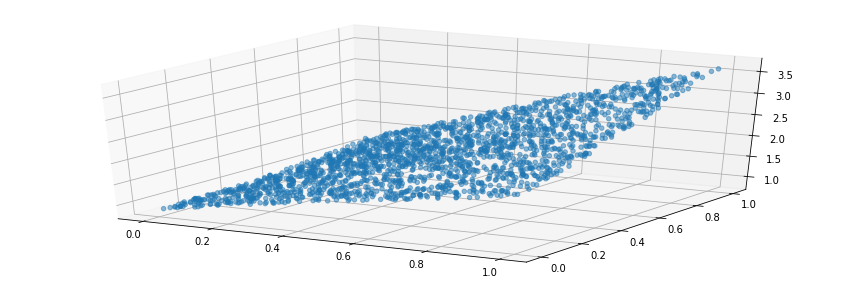

In [438]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_data[:,0],test_data[:,1],output,alpha=0.5)       


In [440]:
with open('6.6.5_results.npy', 'wb') as f:
    np.save(f, output)
